# Comparing performance of belief maximization algorithm with and without observabilities

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sys
sys.path.append('../')

In [3]:
import source.players as pl
import source.parsers as parsers
import source.game as game
import source.player as player
import source.environment as environment
import source.errors as errors
import source.runner as runner
import source.util as util
import source.players.attackers as attackers
import source.players.base_defenders as base_defenders
import source.players.defenders as defenders
import source.players.holmes as holmes
import source.players.sad as sad
import source.players.b2bw2w as b2bw2w
import source.players.belief_max as bm

import concurrent.futures
import pkgutil
import logging
import sys
from source.util import *
import numpy as np
import pandas as pd
from importlib import *
import time
import os
import re
from copy import deepcopy, copy
import datetime
from contextlib import redirect_stdout

In [4]:
# run once

lvl = logging.DEBUG
logger = logging.getLogger("source")
logger.setLevel(lvl)
#ch = logging.StreamHandler(sys.stdout)
ch = logging.FileHandler("status", mode='w')
ch.setLevel(lvl)
#formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
formatter = logging.Formatter('%(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)

In [5]:
lvl = logging.WARNING
logger.setLevel(lvl)
ch.setLevel(lvl)

In [6]:
# if you change something in the files, don't forget to reload
reload(player)
reload(base_defenders)
reload(attackers)
reload(defenders)
reload(errors)
reload(environment)
reload(runner)
reload(parsers)
reload(game)
reload(holmes)
reload(sad)
reload(b2bw2w)
reload(util)
reload(bm)

<module 'source.players.belief_max' from '..\\source\\players\\belief_max.py'>

In [7]:
time_horizon = 1000
T = 5
#targets = util.gen_targets(T, low=1, high=10)
targets = [5, 3, 8, 4, 9]
values = tuple((v, v) for v in targets)
#obs = gen_observabilities_correlated_with_values(values)
obs = {0: 0.75, 1: 0.75, 2: 0.75, 3: 0.75, 4: 0.75}
obs_vect = [obs.get(i) for i in range(len(targets))]
distributions = []
for i in range(20):
    distributions.append(tuple(util.gen_distr(T)))

In [8]:
g1 = game.Game(values, time_horizon)
g1.attackers = [1]
g1.defenders = [0]
a1 = [attackers.StackelbergAttacker(g1, 1)]
d1 = [bm.FB(g1, 0)]
p1 = [attackers.StackelbergAttacker(g1, 1)]
stoc_prof = []
for d in distributions:
    stoc_prof.append(attackers.StochasticAttacker(g1, 1, 1, *d))
att_prof = [attackers.StackelbergAttacker(g1, 1)]
stoc_prof_and_att = stoc_prof + att_prof
g1.set_players(d1, a1, stoc_prof_and_att)

go1 = game.GameWithObservabilities(values, time_horizon)
go1.attackers = [1]
go1.defenders = [0]
a1 = [attackers.StackelbergAttacker(go1, 1)]
d1 = [bm.FB(go1, 0)]
p1 = [attackers.StackelbergAttacker(go1, 1)]
stoc_prof1 = []
for d in distributions:
    stoc_prof1.append(attackers.StochasticAttacker(go1, 1, 1, *d))
att_prof1 = [attackers.StackelbergAttacker(go1, 1)]
stoc_prof_and_att1 = stoc_prof1 + att_prof1
go1.set_players(d1, a1, stoc_prof_and_att1)

In [9]:
def print_header(targets, profiles, observabilities):
    return "Name,T," + ",".join(str(i) for i in range(len(targets))) + ",Defender,Attacker," + ",".join(["Profile" for x in range(len(profiles))]) + "," + ",".join(["Obs" + str(i) for i in range(len(observabilities))]) + "\n" 

In [10]:
def print_row(targets, game_type, time_horizon, d, a, p, obs):
    return ",".join([str(i) for i in ([d+"_vs_"+a+"_"+game_type] + [time_horizon] + targets + [d] + [a] + [x for x in p] + obs) ])+"\n"

In [11]:
(print_header(targets, stoc_prof_and_att, obs_vect))

'Name,T,0,1,2,3,4,Defender,Attacker,Profile,Profile,Profile,Profile,Profile,Profile,Profile,Profile,Profile,Profile,Profile,Profile,Profile,Profile,Profile,Profile,Profile,Profile,Profile,Profile,Profile,Obs0,Obs1,Obs2,Obs3,Obs4\n'

In [12]:
defender =["FB1", "FB1"]

In [13]:
profiles = []
for p in stoc_prof_and_att:
    profiles.append(util.print_adv(p))
profiles1 = []
for p in stoc_prof_and_att1:
    profiles1.append(util.print_adv(p))

In [14]:
experiments_folder = "../NewExperiments"
exp_subfolder = "/Exp1"
batch_name = "belief_max_obs_vs_no_obs"
batch_file = batch_name + ".csv"
batch_path = experiments_folder + exp_subfolder + "/" + batch_file

In [15]:
with open(batch_path, "w+") as f:
    f.write(print_header(targets, stoc_prof_and_att, obs_vect))
    f.write(print_row(targets, "no_obs", time_horizon,defender[0],"sta1",profiles,[]))
    f.write(print_row(targets, "obs", time_horizon,defender[1],"sta1",profiles1, obs_vect))

In [16]:
pd.read_csv(batch_path)

,Name,T,0,1,2,3,4,Defender,Attacker,Profile,...,Profile.16,Profile.17,Profile.18,Profile.19,Profile.20,Obs0,Obs1,Obs2,Obs3,Obs4
0,FB1_vs_sta1_no_obs,1000,5,3,8,4,9,FB1,sta1,sto1-0.22322322322322322-0.2142142142142142-0....,...,sto1-0.3186813186813187-0.1228771228771229-0.0...,sta1,sto1-0.033-0.144-0.021-0.114-0.688,sto1-0.023976023976023973-0.03196803196803197-...,sto1-0.5344655344655345-0.25274725274725274-0....,NaN,NaN,NaN,NaN,NaN
1,FB1_vs_sta1_obs,1000,5,3,8,4,9,FB1,sta1,sto1-0.162-0.72-0.004-0.091-0.023,...,sta1,sto1-0.5344655344655345-0.25274725274725274-0....,sto1-0.1118881118881119-0.16983016983016985-0....,sto1-0.198-0.029-0.072-0.354-0.347,sto1-0.246-0.047-0.147-0.223-0.337,0.75,0.75,0.75,0.75,0.75


In [17]:
#os.mkdir("../NewExperiments/Exp1/belief_max_obs_vs_no_obs")

In [18]:
b = runner.Batch(batch_path, experiments_folder + exp_subfolder)

In [19]:
b.parse_batch()

In [20]:
batches = []
batches.append(b)

In [21]:
with concurrent.futures.ProcessPoolExecutor(None) as executor:
    futures = {}
    logger.info(str(datetime.datetime.now()))
    for b in batches:
        b.run(futures, executor, n=2)

In [22]:
with open('progress', 'w') as f:
    with redirect_stdout(f):
        for b in batches:
            b.collect(futures)
            confs = b.configurations
            print(b.results_folder_path)
            dlist = [{"name": c.game.players[0].__class__.name,
                      "avgs": c.stats["exp_regret"], 
                      "lb": c.stats["lb_exp_regret"],
                      "ub": c.stats["ub_exp_regret"]}
                     for c in confs]
            util.plot_dicts(dlist, save=True, show=False, semilog=True,
                            path=b.results_folder_path,
                            title=confs[0].game.players[1].__class__.name)

FileNotFoundError: [Errno 2] No such file or directory: '/FB1_vs_sta1_no_obs/figure.pdf'

C:\Users\Mattia\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


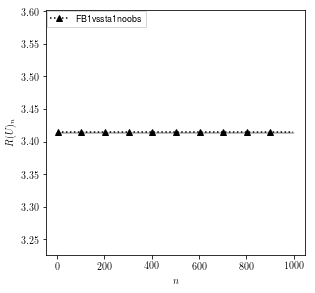

In [25]:
confs = [c for c in batches[0].configurations]
cdict = {}
for c in confs:
    cname = c.name.split(" vs")[0]
    if cname not in cdict:
        cdict[cname] = [c]
    else:
        cdict[cname].append(c)
    dlist = []
    for n in cdict:
        avg_regrets = [c.stats["exp_regret"] for c in cdict[n]]
        d = util.avg_with_conf(avg_regrets, name="".join(n.split("_")))
        dlist.append(d)
    batch_subfolder = "/" + cname
    util.plot_dicts(dlist, save=True, show=False, semilog=False,
            path=os.path.join(experiments_folder, exp_subfolder, batch_subfolder))

In [26]:
gm = deepcopy(batches[0].configurations[1].game)

In [27]:
gm

<GameWithObservabilities values:[[5.0, 5.0], [3.0, 3.0], [8.0, 8.0], [4.0, 4.0], [9.0, 9.0]] players{1: <StackelbergAttacker id:1 resources:1>, 0: <FB id:0 resources:1>} time_horizon:1000>

In [28]:
e = runner.Experiment(gm)

In [29]:
for i in range(900):
    e.run_interaction_with_observations()
    print(e.game.strategy_history[-1])
    #print(util.game_str(e.game, lenght=7))
    print(e.game.history[-1])
    print(e.game.observation_history[-1])
    #print(list(e.agent.belief.pr.items())[2])

{0: (0, 0, 0, 0, 1), 1: [0, 0, 1, 0, 0]}
{1: [2], 0: [4]}
{0: 0, 1: 1, 2: 1, 3: 1, 4: 0}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [2]}
{0: 1, 1: 1, 2: 0, 3: 1, 4: 0}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 1, 1: 1, 2: 0, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [2]}
{0: 1, 1: 1, 2: 1, 3: 0, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.426751592

{0: (0, 0, 0, 0, 1), 1: [0, 0, 1, 0, 0]}
{1: [2], 0: [4]}
{0: 1, 1: 1, 2: 1, 3: 0, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [2]}
{0: 1, 1: 0, 2: 1, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 1, 1: 1, 2: 1, 3: 0, 4: 0}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [2]}
{0: 1, 1: 0, 2: 1, 3: 0, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [2]}
{0: 0, 1: 1, 2: 1, 3: 0, 4: 1}
{0: (0, 0, 0, 0, 1), 1: [0, 0, 1, 0, 0]}
{1: [2], 0: [4]}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [0]}
{0: 1, 1: 0, 2: 0, 3: 0, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}


{0: (0, 0, 0, 0, 1), 1: [0, 0, 1, 0, 0]}
{1: [2], 0: [4]}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 0, 1: 0, 2: 1, 3: 1, 4: 1}
{0: (0, 0, 0, 0, 1), 1: [0, 0, 1, 0, 0]}
{1: [2], 0: [4]}
{0: 1, 1: 1, 2: 1, 3: 0, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [2]}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [2]}
{0: 1, 1: 1, 2: 1, 3: 0, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 1, 1: 0, 2: 1, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}


{0: (0, 0, 0, 0, 1), 1: [0, 0, 1, 0, 0]}
{1: [2], 0: [4]}
{0: 1, 1: 1, 2: 0, 3: 1, 4: 0}
{0: (0, 0, 0, 0, 1), 1: [0, 0, 1, 0, 0]}
{1: [2], 0: [4]}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 0}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [2]}
{0: 1, 1: 1, 2: 1, 3: 0, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 0, 1: 1, 2: 0, 3: 1, 4: 1}
{0: (0, 0, 0, 0, 1), 1: [0, 0, 1, 0, 0]}
{1: [2], 0: [4]}
{0: 1, 1: 0, 2: 1, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 0, 1: 1, 2: 1, 3: 1, 4: 1}
{0: (0, 

{1: [0], 0: [2]}
{0: 1, 1: 1, 2: 0, 3: 1, 4: 0}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [2]}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 0}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [0]}
{0: 0, 1: 0, 2: 1, 3: 1, 4: 1}
{0: (0, 0, 0, 0, 1), 1: [0, 0, 1, 0, 0]}
{1: [2], 0: [4]}
{0: 0, 1: 1, 2: 0, 3: 1, 4: 0}
{0: (0, 0, 0, 0, 1), 1: [0, 0, 1, 0, 0]}
{1: [2], 0: [4]}
{0: 1, 1: 1, 2: 1, 3: 0, 4: 0}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [2]}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [2]}
{0: 1, 1: 1, 2: 0, 3: 1, 4: 0}
{0: [0.0828025477706999, 0.0, 0.42675159235668786

{1: [2], 0: [4]}
{0: 1, 1: 1, 2: 0, 3: 1, 4: 1}
{0: (0, 0, 0, 0, 1), 1: [0, 0, 1, 0, 0]}
{1: [2], 0: [4]}
{0: 0, 1: 0, 2: 1, 3: 1, 4: 0}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 0}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 1, 1: 0, 2: 1, 3: 1, 4: 0}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [2]}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 0}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 0, 1: 1, 2: 0, 3: 1, 4: 1}
{0: (0, 0, 0, 0, 1), 1: [0, 0, 1, 0, 0]}
{1: [2], 0: [4]}
{0: 0, 1: 1, 2: 1, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 1, 1: 1, 2: 0, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786

{0: 1, 1: 0, 2: 0, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [2]}
{0: 0, 1: 1, 2: 1, 3: 1, 4: 1}
{0: (0, 0, 0, 0, 1), 1: [0, 0, 1, 0, 0]}
{1: [2], 0: [4]}
{0: 0, 1: 1, 2: 1, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [2]}
{0: 1, 1: 0, 2: 0, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 1, 1: 1, 2: 0, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [2]}
{0: 1, 1: 1, 2: 1, 3: 0, 4: 1}
{0: [0.082

{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 0, 1: 1, 2: 1, 3: 1, 4: 0}
{0: (0, 0, 0, 0, 1), 1: [0, 0, 1, 0, 0]}
{1: [2], 0: [4]}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 0, 1: 1, 2: 1, 3: 1, 4: 1}
{0: (0, 0, 0, 0, 1), 1: [0, 0, 1, 0, 0]}
{1: [2], 0: [4]}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 0}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 1, 1: 1, 2: 0, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [2]}
{0: 0, 1: 0, 2: 0, 3: 1, 4: 0}
{0: (0, 0, 0, 0, 1), 1: [0, 0, 1, 0, 0]}
{1: [2], 0: [4]}
{0: 1, 1: 0, 2: 0, 3: 1, 4: 1}
{0: (0, 0, 0, 0, 1), 1: [0, 0, 1, 0, 0]}
{1: [2], 0: [4]}
{0: 0, 1: 0, 2: 1, 3: 0, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.490445

{0: (0, 0, 0, 0, 1), 1: [0, 0, 1, 0, 0]}
{1: [2], 0: [4]}
{0: 1, 1: 1, 2: 0, 3: 1, 4: 1}
{0: (0, 0, 0, 0, 1), 1: [0, 0, 1, 0, 0]}
{1: [2], 0: [4]}
{0: 1, 1: 0, 2: 0, 3: 1, 4: 1}
{0: (0, 0, 0, 0, 1), 1: [0, 0, 1, 0, 0]}
{1: [2], 0: [4]}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 0}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 0, 1: 1, 2: 1, 3: 1, 4: 1}
{0: (0, 0, 0, 0, 1), 1: [0, 0, 1, 0, 0]}
{1: [2], 0: [4]}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [2]}
{0: 1, 1: 1, 2: 1, 3: 0, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 1, 1: 1, 2: 1, 3: 0, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [2]}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 0}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.490445

{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 1, 1: 1, 2: 1, 3: 0, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 0, 1: 0, 2: 1, 3: 1, 4: 1}
{0: (0, 0, 0, 0, 1), 1: [0, 0, 1, 0, 0]}
{1: [2], 0: [4]}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 0}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 1, 1: 1, 2: 0, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 1, 1: 1, 2: 0, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 1, 1: 1, 2: 1, 3: 0, 4: 1}
{0: [0.0828025477706999, 0.0, 0.42675159235668786, 0.0, 0.4904458598726123], 1: [1, 0, 0, 0, 0]}
{1: [0], 0: [4]}
{0: 1, 1: 1, 2: 0, 3: 1, 4: 1}
{0: [0.0828025477706999, 0.0, 0.426751592

In [30]:
e.game

<GameWithObservabilities values:[[5.0, 5.0], [3.0, 3.0], [8.0, 8.0], [4.0, 4.0], [9.0, 9.0]] players{1: <StackelbergAttacker id:1 resources:1>, 0: <FB id:0 resources:1>} time_horizon:1000>

In [31]:
e.agent.belief.loglk

{<StochasticAttacker id:1 resources:1>: -0.0013880806261728884,
 <StochasticAttacker id:1 resources:1>: -0.0040998655049411335,
 <StochasticAttacker id:1 resources:1>: -0.004666338975422141,
 <StackelbergAttacker id:1 resources:1>: 0.0,
 <StochasticAttacker id:1 resources:1>: -0.004240792028470912,
 <StochasticAttacker id:1 resources:1>: -0.003860852860922305,
 <StochasticAttacker id:1 resources:1>: -0.002753264422746563,
 <StochasticAttacker id:1 resources:1>: -0.0016185742504627072,
 <StochasticAttacker id:1 resources:1>: -0.0008946629826317424,
 <StochasticAttacker id:1 resources:1>: -0.0007994346176661637,
 <StochasticAttacker id:1 resources:1>: -0.0022841389056250222,
 <StochasticAttacker id:1 resources:1>: -0.0006462286731411532,
 <StochasticAttacker id:1 resources:1>: -0.0015537410470601776,
 <StochasticAttacker id:1 resources:1>: -0.0010136696563291107,
 <StochasticAttacker id:1 resources:1>: -0.0021303585468926676,
 <StochasticAttacker id:1 resources:1>: -0.0014144063064587637